In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
from scipy.signal import savgol_filter, savgol_coeffs
from scipy.optimize import curve_fit
import scipy

## 2x2 model

In [2]:
# Counting all possible energies and magnetizations
for i in [-1, 1]:
    for j in [-1, 1]:
        for k in [-1, 1]:
            for l in [-1, 1]:
                E = 2 * (i * j + i * k + l * j + l * k)
                M = i + j + k + l
                print(f"E = {E}, M = {M}")

E = 8, M = -4
E = 0, M = -2
E = 0, M = -2
E = 0, M = 0
E = 0, M = -2
E = 0, M = 0
E = -8, M = 0
E = 0, M = 2
E = 0, M = -2
E = -8, M = 0
E = 0, M = 0
E = 0, M = 2
E = 0, M = 0
E = 0, M = 2
E = 0, M = 2
E = 8, M = 4


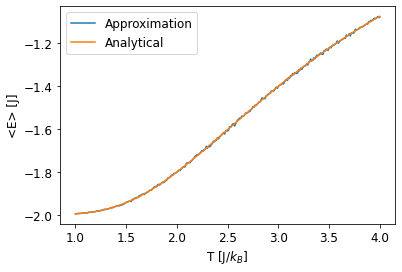

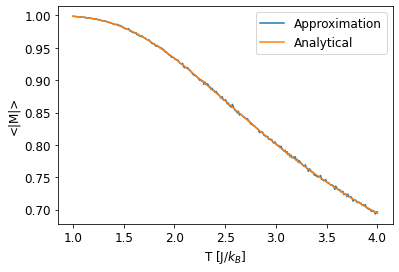

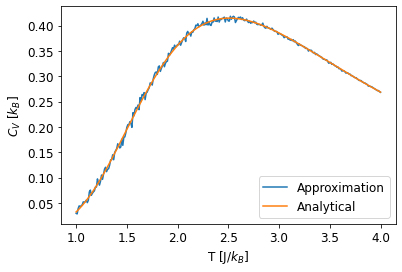

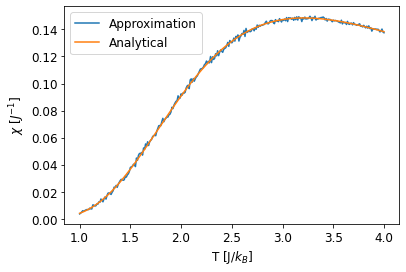

In [3]:
def Z(T):
    return 2 * np.exp(-8/T) + 2 * np.exp(8/T) + 12
def E(T):
    return 1/Z(T) * (8 * 2 * np.exp(-8/T) - 8 * 2 * np.exp(8/T)) / 4
def E2(T):
    return 1/Z(T) * (64 * 2 * np.exp(-8/T) + 64 * 2 * np.exp(8/T)) / 4
def M(T):
    return 1/Z(T) * (4 * 2 * np.exp(8/T) + 2 * 8) / 4
def M2(T):
    return 1/Z(T) * (16 * 2 * np.exp(8/T) + 4 * 8) / 4
def CV(T):
    return 1/T**2 * (E2(T) - E(T)**2 * 4)
def X(T):
    return 1/T * (M2(T) - M(T)**2 * 4)

def plot2x2(val, func, ylabel):
    filename = f"Output/2x2.txt"
    df = pd.read_csv(filename, delim_whitespace=True)
    T = df["T"]
    value = df[val]
    plt.plot(T, value, label = f"Approximation")
    plt.plot(T, func(T), label = f"Analytical")
    plt.legend(loc = "best")
    plt.xlabel(r"T [J/$k_B$]")
    plt.ylabel(ylabel)
    plt.show()
    
plot2x2("E", E, ylabel = r"<E> [J]")
plot2x2("|M|", M, ylabel = "<|M|>")
plot2x2("Cv", CV, ylabel = r"$C_V$ [$k_B$]")
plot2x2("X", X, ylabel = r"$\chi$ [$J^{-1}$]")

## Timing

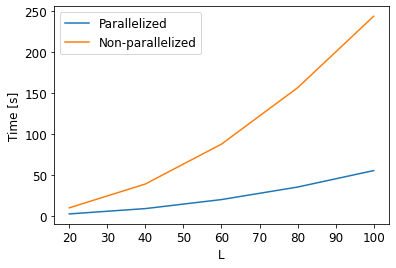

[4.30256681 4.43273036 4.42538086 4.45767859 4.41721535]


In [4]:
Ls = [20, 40, 60, 80, 100]
para = np.array([2.25299, 8.76153, 19.7905, 35.1028, 55.2228])
nonpara = np.array([9.69364, 38.8375, 87.5805, 156.477, 243.931])
plt.plot(Ls, para, label="Parallelized")
plt.plot(Ls, nonpara, label="Non-parallelized")
plt.xlabel("L")
plt.ylabel("Time [s]")
plt.legend()
plt.show()

In [20]:
ratios = nonpara/para
print(ratios)
print(np.mean(ratios))
print(np.std(ratios))

[4.30256681 4.43273036 4.42538086 4.45767859 4.41721535]
4.407114395009697
0.05399778849287945


## P(E)

0.14257562066232524
0.007648494842941297


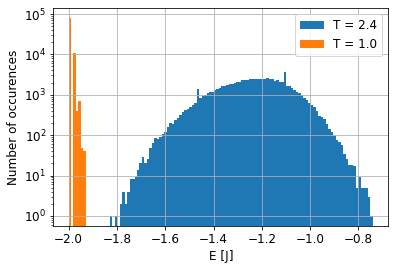

In [38]:
start = 10000
df = pd.read_csv("Output/tte/T24rand.txt", delim_whitespace=True)
E = np.array(df["E"][start:])
plt.hist(E, len(set(E)), label="T = 2.4")
print(np.std(E))

df = pd.read_csv("Output/tte/T1rand.txt", delim_whitespace=True)
E = df["E"][start:]
plt.hist(E, len(set(E)), label="T = 1.0")
print(np.std(E))
plt.yscale("log")
plt.ylabel("Number of occurences")
plt.xlabel("E [J]")
plt.legend()
plt.grid()
plt.show()

## Time to equilibrium

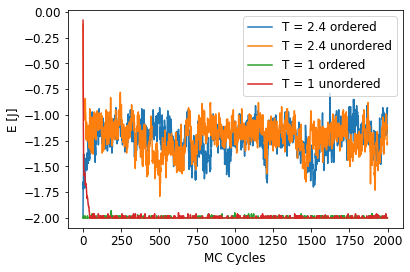

In [9]:
def plot_mc(file, val, label, end):
    df = pd.read_csv(file, delim_whitespace=True)
    y = df[val]
    plt.plot(y[:end], label = label)
    
end = 2000
plot_mc("Output/tte/T24.txt", "E", r"T = 2.4 ordered", end)
plot_mc("Output/tte/T24rand.txt", "E", r"T = 2.4 unordered", end)
plot_mc("Output/tte/T1.txt", "E", r"T = 1 ordered", end)
plot_mc("Output/tte/T1rand.txt", "E", r"T = 1 unordered", end)

plt.legend(loc="upper right")
plt.ylabel("E [J]")
plt.xlabel("MC Cycles")
plt.show()

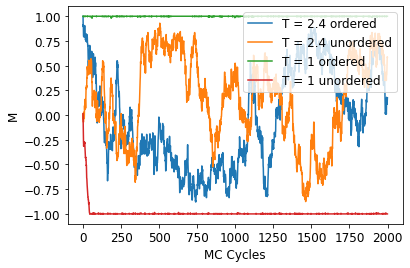

In [10]:
end = 2000
plot_mc("Output/tte/T24.txt", "M", r"T = 2.4 ordered", end)
plot_mc("Output/tte/T24rand.txt", "M", r"T = 2.4 unordered", end)
plot_mc("Output/tte/T1.txt", "M", r"T = 1 ordered", end)
plot_mc("Output/tte/T1rand.txt", "M", r"T = 1 unordered", end)

plt.legend(loc="upper right")
plt.ylabel("M")
plt.xlabel("MC Cycles")
plt.show()

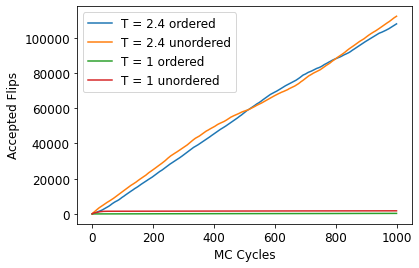

In [11]:
end = 1000
plot_mc("Output/tte/T24.txt", "A", r"T = 2.4 ordered", end)
plot_mc("Output/tte/T24rand.txt", "A", r"T = 2.4 unordered", end)
plot_mc("Output/tte/T1.txt", "A", r"T = 1 ordered", end)
plot_mc("Output/tte/T1rand.txt", "A", r"T = 1 unordered", end)

plt.legend(loc="upper left")
plt.ylabel("Accepted Flips")
plt.xlabel("MC Cycles")
plt.show()

## $T_C$

### Expected values as function of T

In [40]:
def plotVal(val, ylabel):
    for L in [20, 40, 60, 80, 100]:
        filename = f"Output/0_001/{L}e7rnd.txt"
        df = pd.read_csv(filename, delim_whitespace=True)
        T = df["T"]
        value = df[val]
        plt.plot(T, value, label = f"L = {L}")

    plt.legend(loc = "best")
    plt.xlabel(r"T [J/$k_B$]")
    plt.ylabel(ylabel)
    plt.show()

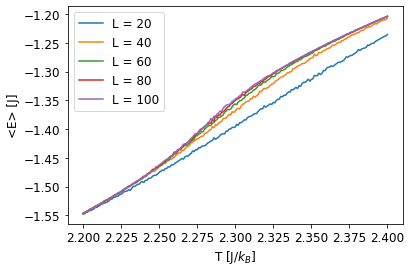

In [6]:
plotVal("E", ylabel = "<E> [J]")

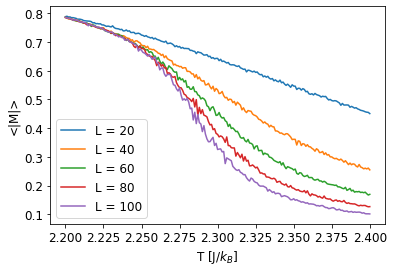

In [7]:
plotVal("|M|", ylabel = "<|M|>")

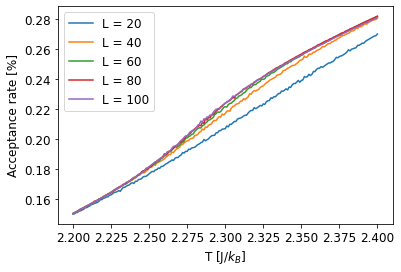

In [61]:
for L in [20, 40, 60, 80, 100]:
    filename = f"Output/0_001/{L}e7rnd.txt"
    df = pd.read_csv(filename, delim_whitespace=True)
    T = df["T"]
    value = np.array(df["A"])
    # Fixing an integer overflow issue. Takes too long to fix it directly
    overflow = 0
    for i, v in enumerate(value):
        if value[i] < 0:
            if overflow == 0:
                overflow = value[i - 1]
                start = value[i]
                value[i] = overflow + value[i] - start
            else:
                value[i] = overflow + value[i] - start
    plt.plot(T, value, label = f"L = {L}")

plt.legend(loc = "best")
plt.xlabel(r"T [J/$k_B$]")
plt.ylabel("Acceptance rate [%]")
plt.show()

### With $C_V$

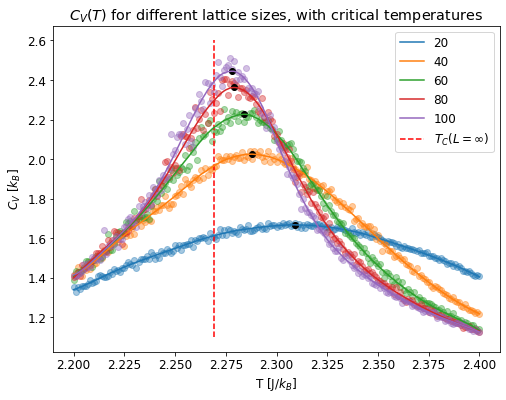

In [12]:
T_Cs = []
L_vals = []

plt.figure(figsize=(8,6))
for L in [20, 40, 60, 80, 100]:
    filename = f"Output/0_001/{L}e7rnd.txt"
    df = pd.read_csv(filename, delim_whitespace=True)
    T = df["T"]
    Cv = df["Cv"]
    Cv_smooth = savgol_filter(Cv, 101, 6)
    plt.scatter(T, Cv, alpha=0.4)
    plt.plot(T, Cv_smooth, label = L)
    plt.scatter(T[Cv_smooth.argmax()], Cv_smooth.max(), color="black")
    
    T_Cs.append(T[Cv_smooth.argmax()])
    L_vals.append(L)
    
plt.vlines([2.269], ymin=1.1, ymax=2.6, linestyles="dashed", color="red", label=r"$T_C(L=\infty)$")
plt.legend(loc = "upper right")
plt.title(r"$C_V(T)$ for different lattice sizes, with critical temperatures")
plt.xlabel(r"T [J/$k_B$]")
plt.ylabel(r"$C_V$ [$k_B$]")
plt.show()

Predicted = 2.2699, actual = 2.269185314213022, diff = 0.0007


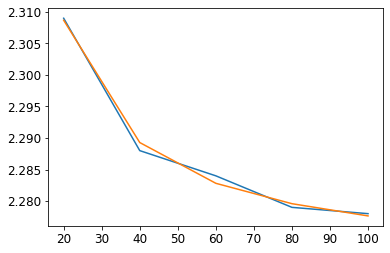

In [13]:
y = np.array(T_Cs)
x = np.array(L_vals)

coefs = np.polyfit(1/x, y, 1)
T_C = coefs[1]
T_C_real = 2/np.log(1 + 2**0.5)
print(f"Predicted = {T_C:.4f}, actual = {T_C_real}, diff = {(T_C - T_C_real):.4f}")
#2.269
plt.plot(x, y)
plt.plot(x, coefs[1] + coefs[0] / x)
plt.show()

### With $\chi$

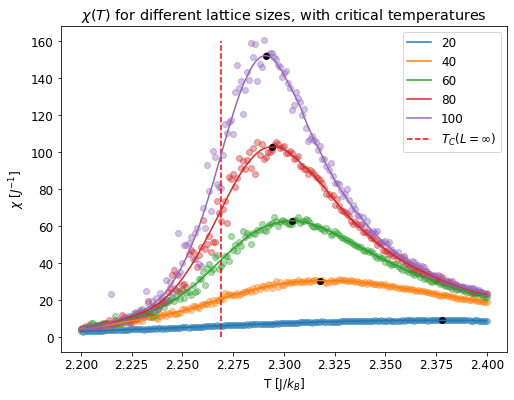

In [18]:
T_Cs = []
L_vals = []

plt.figure(figsize=(8,6))
for L in [20, 40, 60, 80, 100]:
    filename = f"Output/0_001/{L}e7rnd.txt"
    df = pd.read_csv(filename, delim_whitespace=True)
    T = df["T"]
    X = df["X"]
    X_smooth = savgol_filter(X, 101, 6)
    plt.scatter(T, X, alpha=0.4)
    plt.plot(T, X_smooth, label = L)
    plt.scatter(T[X_smooth.argmax()], X_smooth.max(), color="black")
    
    T_Cs.append(T[X_smooth.argmax()])
    L_vals.append(L)
    
plt.vlines([2.269], ymin=0, ymax=160, linestyles="dashed", color="red", label=r"$T_C(L=\infty)$")
plt.legend(loc = "upper right")
plt.title(r"$\chi(T)$ for different lattice sizes, with critical temperatures")
plt.xlabel(r"T [J/$k_B$]")
plt.ylabel(r"$\chi$ [$J^{-1}$]")
plt.show()

Predicted = 2.2669, actual = 2.269185314213022, diff = -0.0023


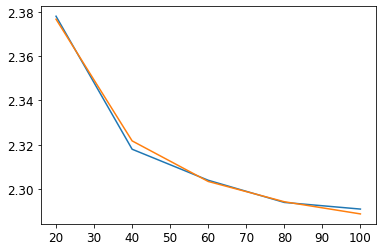

In [15]:
y = np.array(T_Cs)
x = np.array(L_vals)

coefs = np.polyfit(1/x, y, 1)
T_C = coefs[1]
T_C_real = 2/np.log(1 + 2**0.5)
print(f"Predicted = {T_C:.4f}, actual = {T_C_real}, diff = {(T_C - T_C_real):.4f}")
#2.269
plt.plot(x, y)
plt.plot(x, coefs[1] + coefs[0] / x)
plt.show()